# Stage 1. Crop yield prediction. Linear regression. Wheat

In [1]:
# Загрузка всех необходимых библиотек
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
from datetime import datetime
from pyproj import Proj, transform
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, Ridge, PassiveAggressiveRegressor, SGDRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import RANSACRegressor
import pickle

from datetime import date
import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

## Functions

In [2]:
def cum_sum(array, years):
    rcParams['figure.figsize'] = 15, 8
    # Рассчет накопленных сумм
    cumsum_array = np.cumsum(array)
    
    # Рассчитываем среднюю разницу между соседними элементами массива
    diffs = []
    for i in range(0, len(cumsum_array)):
        if i == 0:
            pass
        else:
            last = cumsum_array[i-1]
            current = cumsum_array[i]
            diff = current - last
            diffs.append(diff)
    diffs = np.array(diffs)
    
    # Медианное значение разницы между соседними элементами
    median_diff = np.median(diffs)
    
    # Поиск наиболее заметного перелома:
    fractures = []
    for i in range(0, len(cumsum_array)):
        if i == 0:
            fractures.append(0)
        elif i == 1:
            fractures.append(0)
        else:
            # Используются данные текущего наблюдения + за два предыдущих наблюдения
            pre_last = cumsum_array[i-2]
            last = cumsum_array[i-1]
            current = cumsum_array[i]
            # Действующая разница 
            curr_diff = current - last
            # Разница, которая была на предыдущем шаге
            last_diff = last - pre_last
            # Среднее значение
            main_diff = (curr_diff + last_diff)/2
            
            # Насколько действующая разница больше или меньше среднего значения разности
            value = abs(main_diff - median_diff)
            fractures.append(value)
    fractures = np.array(fractures)
    
    # Условимся считать, что первые 15 и последние 15 элементов в ряду 
    # нам не слудет рассматривать при поиске излома
    new_fractures = fractures[15:-15]
        
    # Допустимый уровень расхожения - 40 процентов
    threshold = ((max(array) - min(array))/100)*40
    # Если хотя бы одно значение из массива больше порогового, то мы имеем дело с изломом
    if any(threshold < fracture for fracture in new_fractures):
        # Индекс "переломного момента"
        id_fracture = np.argwhere(fractures == max(new_fractures))[0][0]
        year_fracture = int(years[id_fracture])
        
        # Линейная регрессия для первой части ряда
        LR1 = LinearRegression()
        years_1 = np.array(years[:id_fracture]).reshape((-1,1))
        cumsum_1 =  np.array(cumsum_array[:id_fracture]).reshape((-1,1))
        LR1.fit(years_1, cumsum_1)
        
        # Линейная регрессия для второй части ряда
        LR2 = LinearRegression()
        years_2 = np.array(years[id_fracture:]).reshape((-1,1))
        cumsum_2 =  np.array(cumsum_array[id_fracture:]).reshape((-1,1))
        LR2.fit(years_2, cumsum_2)
        
        
        # Зададим две точки, по которым будем рисовать прямую
        l1 = np.array([[min(years)], [max(years)]])
        l2 = np.array([[1969], [max(years)]])

        plt.plot(years, cumsum_array, '-ok', c = 'blue', alpha = 0.7, label = 'Cumulative sum')
        plt.plot(l1, LR1.predict(l1), c = 'red', alpha = 0.5, label = 'The first part with extrapolation', linewidth = 3)
        plt.plot(l2, LR2.predict(l2), c = 'orange', alpha = 0.5, label = 'The second part with the extrapolation', linewidth = 3)
        plt.scatter(years[id_fracture], cumsum_array[id_fracture], c = 'yellow', s = 400, alpha = 0.8, label = 'The expected point of fracture')
        plt.xlabel('Year', fontsize = 15)
        plt.ylabel('Cumulative sum', fontsize = 15)
        plt.legend(fontsize = 12)
        plt.grid()
        plt.show()

        print('Estimated fracture year -', year_fracture)
        print('Index of the expected fracture -', id_fracture)
    else:
        print('No fractures were found')
        
# Расчет метрики - cредняя абсолютная процентная ошибка
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    # У представленной ниже формулы есть недостаток, - если в массиве y_true есть хотя бы одно значение 0.0,
    # то по формуле np.mean(np.abs((y_true - y_pred) / y_true)) * 100 мы получаем inf, поэтому
    zero_indexes = np.argwhere(y_true == 0.0)
    for index in zero_indexes:
        y_true[index] = 0.01
    value = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return(value)

# Зададим функцию, которая будет выводить на экран значения метрик
def print_metrics(y_test, prediction, model, r2 = False):
    print('Mean absolute error in the test sample -', mean_absolute_error(y_test, prediction))
    print('Median absolute error in the test sample -', median_absolute_error(y_test, prediction))
    print('Root mean square error in the test sample -', mean_squared_error(y_test, prediction)**0.5)
    print('Mean absolute percentage error in the test sample -',mean_absolute_percentage_error(y_test, prediction))
    if r2 == True:
        print('Coefficient of determination in the training sample -', r2_score(y_train, model.predict(X_train)))

# Зададим функцию для отрисовки графиков
def residuals_plots(y_test, prediction, color = 'blue'):
    prediction = np.ravel(prediction)
    y_test = np.ravel(y_test)
    # Рассчитываем ошибки
    errors = prediction - y_test
    errors = np.ravel(errors)
    
    plot_data = pd.DataFrame({'Errors': errors,
                              'Prediction': prediction})
    
    with sns.axes_style("ticks"):
        g = (sns.jointplot('Prediction', 'Errors',  height = 7, alpha = 0.6,
                           data=plot_data, color= color).plot_joint(sns.kdeplot, zorder=0, n_levels=6))
        g.ax_joint.plot([min(prediction)-0.1, max(prediction)+0.1],[0, 0], linewidth = 1, linestyle='--', color= color)
        g.ax_marg_y.axhline(y = 0, linewidth = 1, linestyle='--', color= color)
        plt.xlabel('Predicted value', fontsize = 15)
        plt.ylabel('Errors, tones/ha', fontsize = 15)
        plt.show()
        
        g = (sns.jointplot('Prediction', 'Errors', kind="kde", data = plot_data, space=0, height = 7,
                      color = color, alpha = 0.2))
        g.set_axis_labels('Predicted value', 'Errors, tones/ha', fontsize = 15)
        g.ax_joint.plot([min(prediction)-0.1, max(prediction)+0.1],[0, 0], linewidth = 1, linestyle='--', color= color)
        g.ax_marg_y.axhline(y = 0, linewidth = 1, linestyle='--', color= color)
        plt.show()

## Germany

Results: 

*   Median absolute error in the test sample - 0.7137
*   MAE in the test sample - 0.6986
*   Root mean square error in the test sample - 0.8721
*   Coefficient of determination in the training sample - 0.070
*   Mean absolute percentage error in the test sample - 9.745

In [3]:
data_germany = pd.read_csv('/media/mikhail/Data/ITMO/Reanalysis_grid_Europe/Processed_grid/Germany.csv', sep = ',')
data_germany.dropna(axis=1, inplace=True)
data_germany.drop('Entity', inplace=True, axis=1)
data_germany.drop('Greece_pressure', inplace=True, axis=1)
data_germany.head(10)

Precip_amount  Precip_days  Pressure_mean  Sweden_pressure  \
0      408.80722         78.0     1012.66360       1002.46170   
1      320.45900         74.0     1011.81710       1003.04160   
2      243.80809         56.0     1011.87775       1009.54596   
3      250.34085         57.0     1014.76843       1008.34420   
4      432.90875         85.0     1010.86523       1004.89140   
5      400.55230         78.0     1010.21100       1007.26660   
6      350.26016         74.0     1012.47205       1002.95180   
7      343.50870         73.0     1011.17490       1002.37256   
8      366.53082         72.0     1009.94324       1009.15950   
9      414.30988         84.0     1008.81020       1005.29070   

   Ireland_pressure  Portugal_pressure  Temperature_max  Temperature_min  \
0         995.21630         1013.98834        28.867697       -15.181596   
1         997.25440         1012.53150        28.243282       -12.794514   
2         993.74610         1009.40594        27.389008       -21.933279   
3         996.31190         1011.71810        30.944390       -15.146607   
4         996.11790         1012.11725        27.001093       -14.974504   
5         990.89276         1011.42180        29.696535       -17.479927   
6         995.52360         1013.38960        29.167023       -14.142985   
7         995.36950         1011.64386        29.295336       -19.096764   
8         992.91064         1009.18420        28.969955       -14.921941   
9         993.67240         1011.54816        29.328340       -16.341478   

   Temperature_SAT  Year  Wheat (tonnes per hectare)  \
0        945.45690  1961                      2.8607   
1        689.46680  1962                      3.3898   
2        896.81760  1963                      3.3934   
3       1026.98790  1964                      3.4845   
4        744.09750  1965                      3.2321   
5       1015.64710  1966                      3.2325   
6        806.55710  1967                      4.0216   
7        948.82947  1968                      4.2162   
8        854.89440  1969                      3.8877   
9        856.11100  1970                      3.7264   

   Maize (tonnes per hectare)  Potatoes (tonnes per hectare)  \
0                      2.8979                        18.0590   
1                      3.2319                        22.5080   
2                      3.4526                        23.1439   
3                      3.3691                        20.9811   
4                      3.5354                        20.5188   
5                      4.0115                        22.2060   
6                      4.6993                        25.3808   
7                      4.8943                        23.9100   
8                      4.8750                        20.7995   
9                      4.9743                        23.1893   

   Peas (tonnes per hectare)  Barley (tonnes per hectare)  \
0                     1.3891                       2.3640   
1                     1.5287                       3.2451   
2                     1.1979                       3.0346   
3                     1.3946                       3.3476   
4                     1.7530                       2.9678   
5                     1.5339                       2.9816   
6                     1.8902                       3.5797   
7                     1.6500                       3.6844   
8                     1.6261                       3.5487   
9                     1.7190                       3.1587   

   Total population (Gapminder)  Land used for cereal (hectares)  \
0                    73928000.0                        7138919.0   
1                    74489000.0                        7145685.0   
2                    75081000.0                        7168885.0   
3                    75677000.0                        7285822.0   
4                    76258000.0                        7229500.0   
5                    76820000.0                 

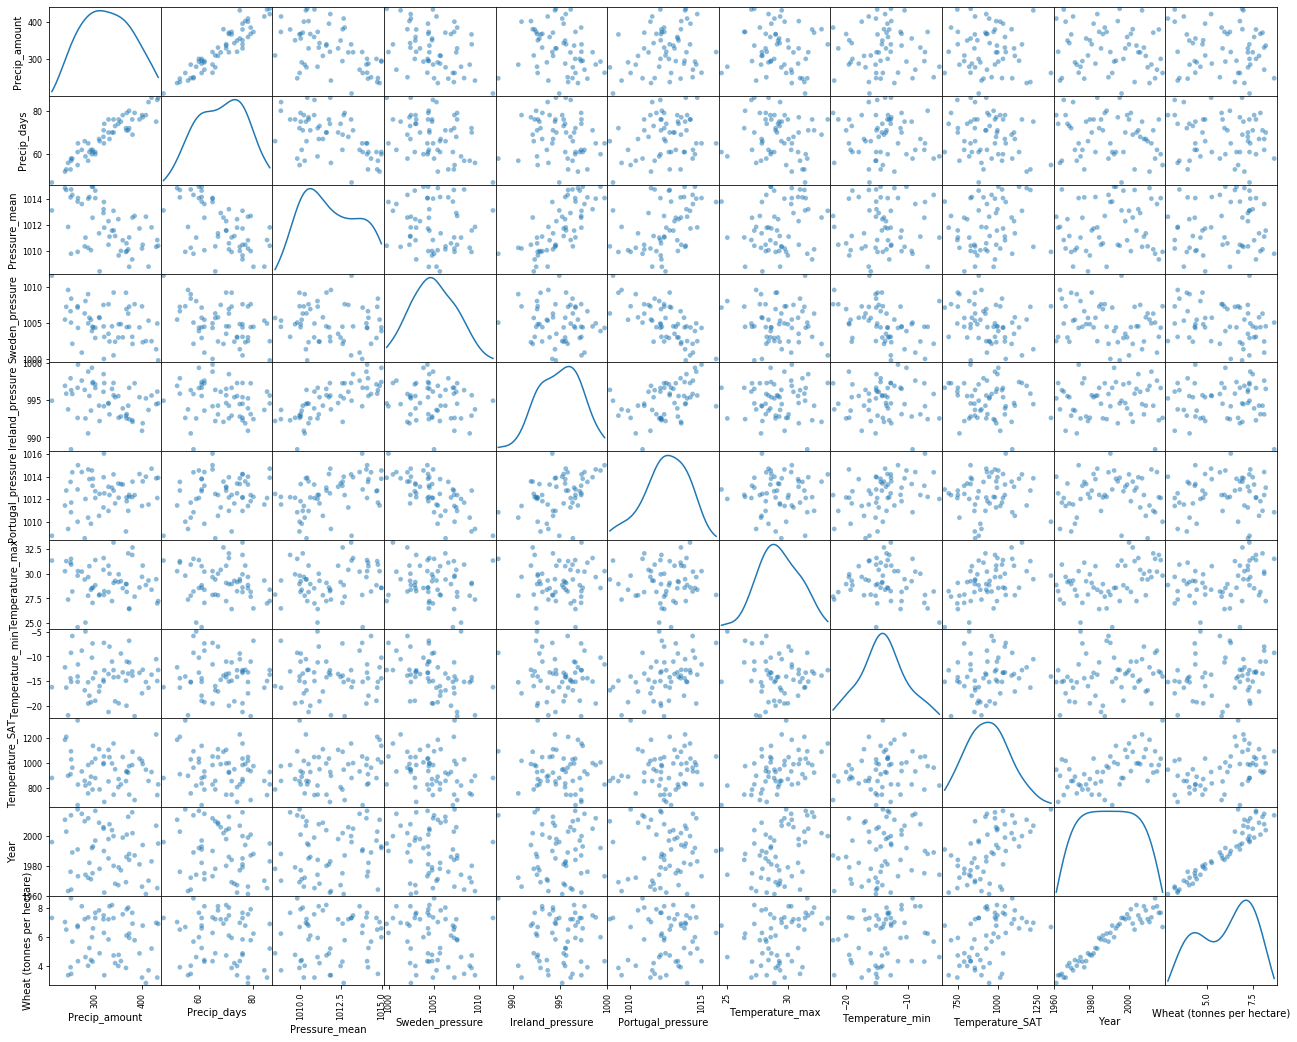

In [4]:
rcParams['figure.figsize'] = 22, 18

pd.plotting.scatter_matrix(data_germany.loc[:, "Precip_amount":"Wheat (tonnes per hectare)"], 
                           diagonal="kde", s = 90)
plt.show()

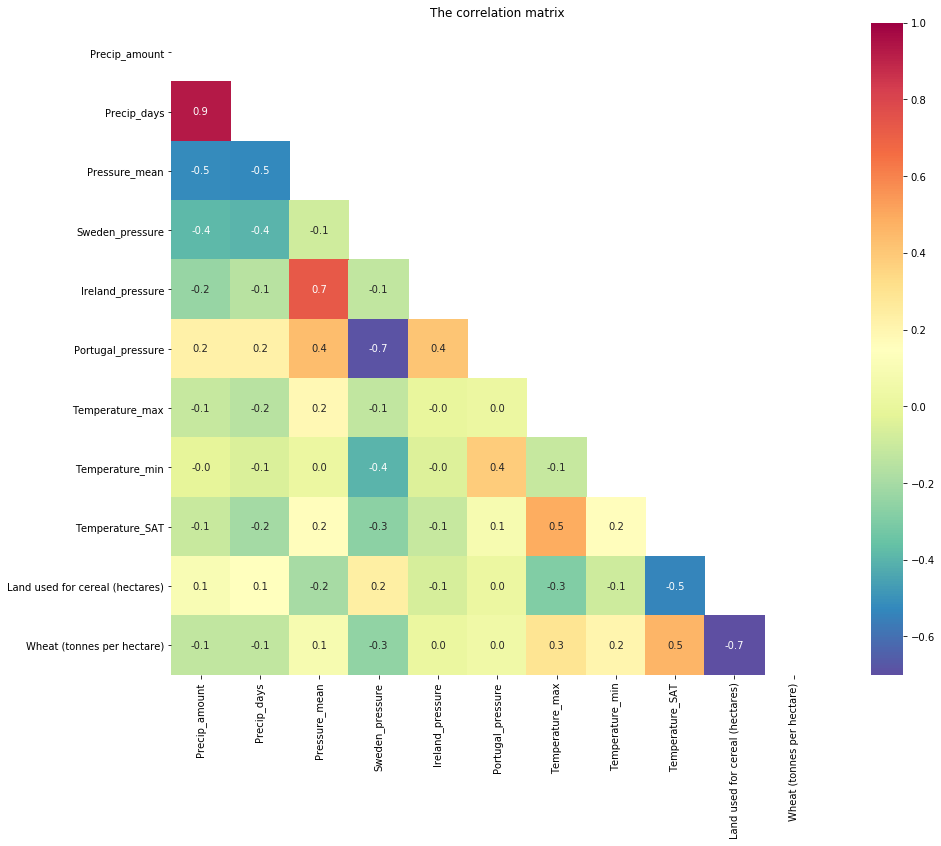

In [5]:
rcParams['figure.figsize'] = 17, 12

Newtable = data_germany[['Precip_amount', 'Precip_days', 'Pressure_mean', 'Sweden_pressure',
                'Ireland_pressure', 'Portugal_pressure', 'Temperature_max', 'Temperature_min',
                'Temperature_SAT','Land used for cereal (hectares)', 'Wheat (tonnes per hectare)']]
Newtable = Newtable.dropna()

corrs = Newtable.corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrs, cmap='Spectral_r', annot=True, fmt= '.1f', mask = mask, square = True)
plt.title('The correlation matrix')
plt.show()

### Checking samples for homogeneity

##### Cumulative sum method and statistical testing to divide the sample into homogeneous parts

The method of integral curves or accumulated (cumulative) sum was initially used in hydrology to check whether or not there are directional changes (trends) in the interannual dynamics of annual river flows. Subsequently, it was used for preliminary analysis of interannual variability of any environmental parameters.

The method is as follows. Graph: x-axis numbers refer to years, y-axis – the accumulated amount of average or total for the year parameter values. The accumulated amount for a given year is the sum of the values of the series from its very beginning to this year. For the first year of the series, this is the value itself, for the second year-the sum of the values of the first and second years, and so on. The points of accumulated sum on the chart are connected by a line. If there is no pronounced inter-annual trend in changing the values of the series, the curve is close to a straight line. If there are breaks on the curve, this may indicate that the sample is not uniform.

In [6]:
cum_sum(data_germany['Wheat (tonnes per hectare)'], data_germany['Year'])

No fractures were found


Thus, we assume that the sample is homogeneous.

### Multiple linear regression

Predictors:
* Precip_amount
* Temperature_SAT
* Precip_days
* Pressure_mean
* Temperature_min
* Year

In [7]:
data_germany['year'] = data_germany['Year']
data_germany.set_index('year', inplace=True)
data_train = data_germany.loc[1961:2003]
data_test = data_germany.loc[2003:2018]

# Предикторы
scaler = StandardScaler()
X_train = scaler.fit_transform(data_train[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min', 'Year']])
X_test = scaler.transform(data_test[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min', 'Year']])
                          
y_train = data_train['Wheat (tonnes per hectare)']
y_test = data_test['Wheat (tonnes per hectare)']
                          
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# Обучение линейной регрессии
LR = LinearRegression()
LR.fit(X_train, y_train)
predicted_Germany = LR.predict(X_test)

### Results

Mean absolute error in the test sample - 0.979724349568986
Median absolute error in the test sample - 0.8580384310611873
Root mean square error in the test sample - 1.1448439204107326
Mean absolute percentage error in the test sample - 13.437359449896086
Coefficient of determination in the training sample - 0.9496156690674019


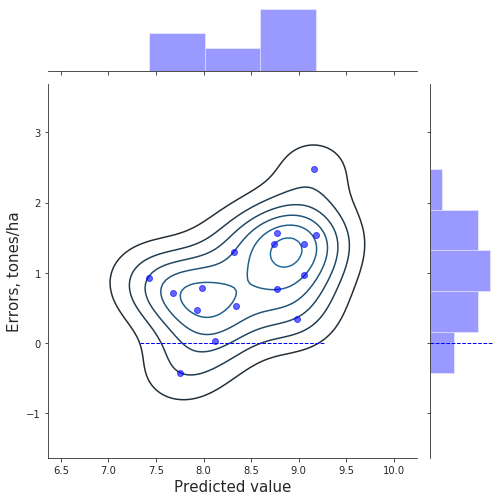

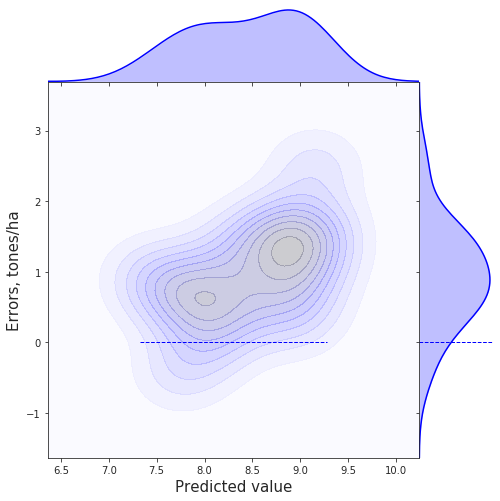

In [8]:
print_metrics(y_test, predicted_Germany, LR, r2 = True)
residuals_plots(y_test, predicted_Germany, color = 'blue')

## France

Results:
* Median absolute error in the test sample - 0.4389
* MAE in the test sample - 0.7177
* Root mean square error in the test sample - 1.0204
* Coefficient of determination in the training sample - 0.5660
* Mean absolute percentage error in the test sample - 11.0776

In [9]:
data_france = pd.read_csv('/media/mikhail/Data/ITMO/Reanalysis_grid_Europe/Processed_grid/France.csv', sep = ',')
data_france.dropna(axis=1, inplace=True)
data_france.drop('Entity', inplace=True, axis=1)
data_france.drop('Greece_pressure', inplace=True, axis=1)
data_france.head(10)

Precip_amount  Precip_days  Pressure_mean  Sweden_pressure  \
0      324.96146         57.0     1007.24774       1002.46170   
1      341.88852         59.0     1006.49133       1003.04160   
2      380.98480         66.0     1003.21857       1009.54596   
3      326.61190         56.0     1006.48865       1008.34420   
4      350.52078         66.0     1013.66675       1004.89140   
5      410.40660         71.0     1010.90375       1007.26660   
6      296.05330         56.0     1006.91370       1002.95180   
7      384.51860         68.0     1001.73690       1002.37256   
8      413.14612         72.0     1006.93054       1009.15950   
9      443.14484         81.0     1010.25480       1005.29070   

   Ireland_pressure  Portugal_pressure  Temperature_max  Temperature_min  \
0         995.21630         1013.98834        29.821554        -4.908166   
1         997.25440         1012.53150        28.480244        -7.935432   
2         993.74610         1009.40594        28.037626       -14.937401   
3         996.31190         1011.71810        29.806044        -8.088913   
4         996.11790         1012.11725        28.755009        -8.207911   
5         990.89276         1011.42180        28.055168       -13.436562   
6         995.52360         1013.38960        28.479153       -10.375815   
7         995.36950         1011.64386        28.142258        -9.456345   
8         992.91064         1009.18420        27.880900        -9.861118   
9         993.67240         1011.54816        27.996424        -8.693648   

   Temperature_SAT  Year  ...  Rice (tonnes per hectare)  \
0        1324.6831  1961  ...                     4.0512   
1         934.0145  1962  ...                     4.1875   
2        1046.3246  1963  ...                     3.9753   
3        1224.4973  1964  ...                     4.0610   
4        1088.6343  1965  ...                     3.2935   
5        1284.2964  1966  ...                     3.6562   
6        1036.3142  1967  ...                     4.3027   
7        1042.6494  1968  ...                     3.4635   
8        1085.4683  1969  ...                     4.1631   
9        1072.1575  1970  ...                     4.2177   

   Maize (tonnes per hectare)  Potatoes (tonnes per hectare)  \
0                      2.5291                        16.0992   
1                      2.1489                        15.5289   
2                      4.0593                        18.9265   
3                      2.3546                        16.7369   
4                      3.9800                        19.5147   
5                      4.5037                        19.7618   
6                      4.0880                        20.1900   
7                      5.2643                        21.3276   
8                      4.8346                        21.5372   
9                      5.0994                        22.2184   

   Beans (tonnes per hectare)  Peas (tonnes per hectare)  \
0                      0.9076                     1.9000   
1                      0.8428                     2.4239   
2                      1.0840                     2.2292   
3                      0.9134                     2.2645   
4                      1.0500                     2.1996   
5                      1.3729                     2.2675   
6                      1.0112                     2.5457   
7                      1.3405                     2.3970   
8                      1.1518                     2.7660   
9                      1.3197                     3.4089   

   Barley (tonnes per hectare)  Total population (Gapminder)  \
0                       2.3960                    46267000.0   
1                       2.7581                    46907000.0   
2                       2.9088                    47561000.0   
3                       2.8774                    48184000.0   
4                       3.0363                    48747000.0   
5                       2.8093         

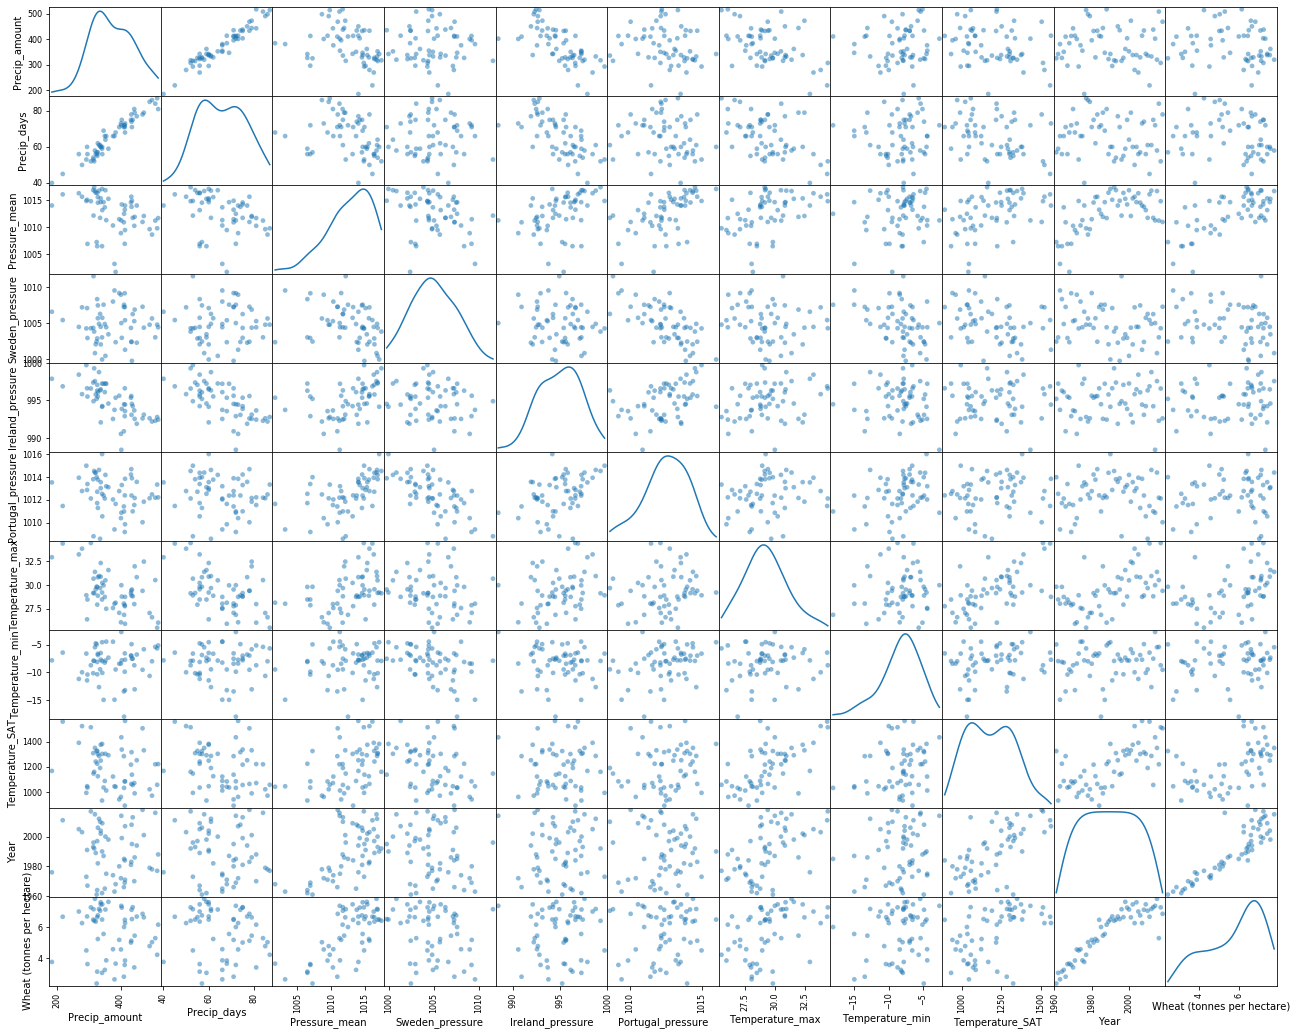

In [10]:
rcParams['figure.figsize'] = 22, 18

pd.plotting.scatter_matrix(data_france.loc[:, "Precip_amount":"Wheat (tonnes per hectare)"], 
                           diagonal="kde", s = 90)
plt.show()

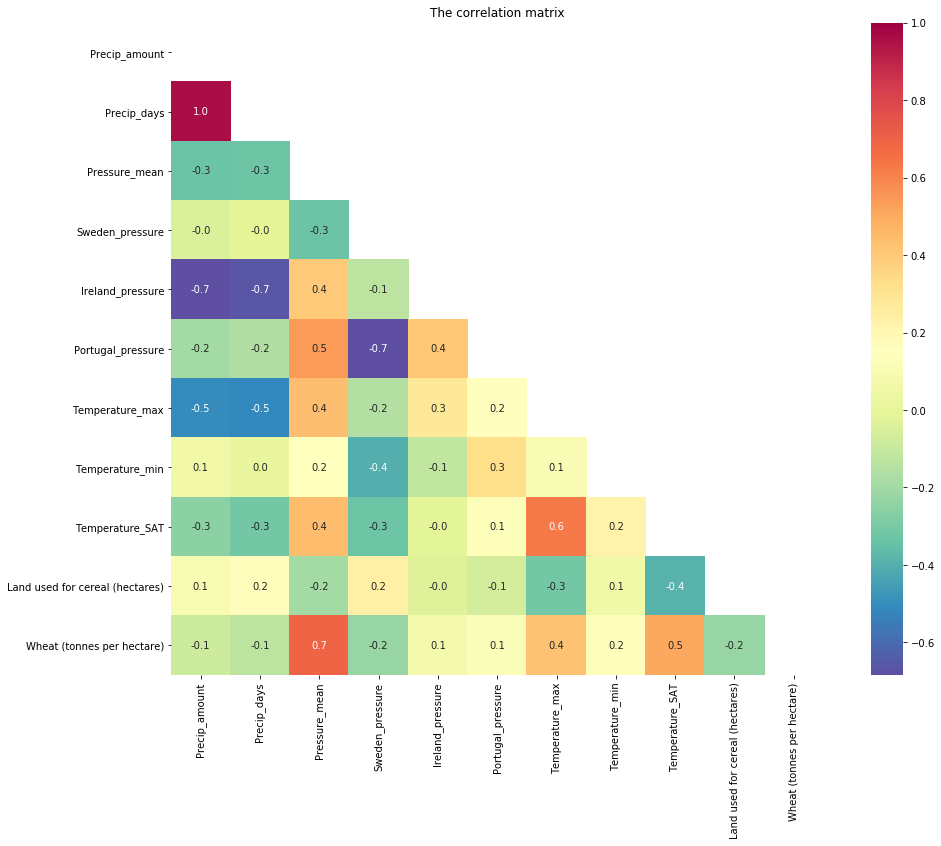

In [11]:
rcParams['figure.figsize'] = 17, 12

Newtable = data_france[['Precip_amount', 'Precip_days', 'Pressure_mean', 'Sweden_pressure',
                'Ireland_pressure', 'Portugal_pressure', 'Temperature_max', 'Temperature_min',
                'Temperature_SAT','Land used for cereal (hectares)', 'Wheat (tonnes per hectare)']]
Newtable = Newtable.dropna()

corrs = Newtable.corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrs, cmap='Spectral_r', annot=True, fmt= '.1f', mask = mask, square = True)
plt.title('The correlation matrix')
plt.show()

### Checking samples for homogeneity

##### Cumulative sum method and statistical testing to divide the sample into homogeneous parts

The method of integral curves or accumulated (cumulative) sum was initially used in hydrology to check whether or not there are directional changes (trends) in the interannual dynamics of annual river flows. Subsequently, it was used for preliminary analysis of interannual variability of any environmental parameters.

The method is as follows. Graph: x-axis numbers refer to years, y-axis – the accumulated amount of average or total for the year parameter values. The accumulated amount for a given year is the sum of the values of the series from its very beginning to this year. For the first year of the series, this is the value itself, for the second year-the sum of the values of the first and second years, and so on. The points of accumulated sum on the chart are connected by a line. If there is no pronounced inter-annual trend in changing the values of the series, the curve is close to a straight line. If there are breaks on the curve, this may indicate that the sample is not uniform.


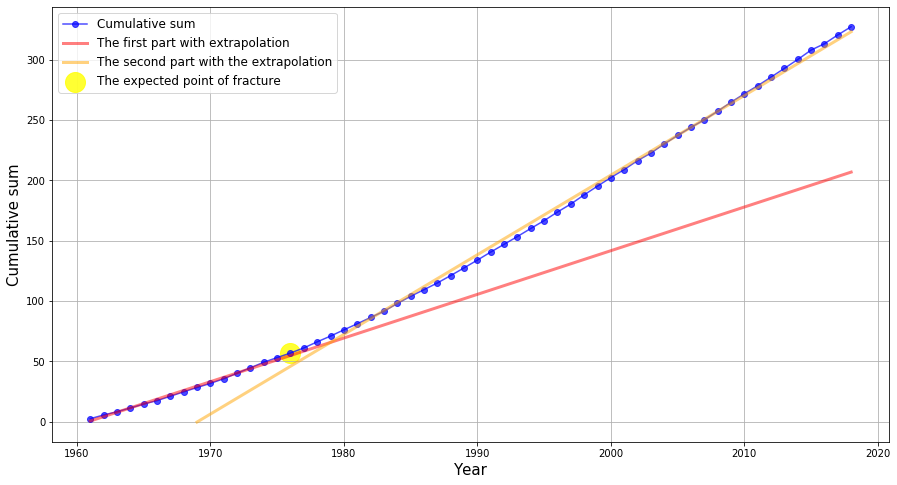

Estimated fracture year - 1976
Index of the expected fracture - 15


In [12]:
cum_sum(data_france['Wheat (tonnes per hectare)'], data_france['Year'])

So, the graph shows the fracture point.

In other words, we can now divide the sample into 2 parts, the first before 1976, and the second after 1976. Then check the samples for belonging to the same general population. We'll do that.

In [13]:
arr = data_france['Wheat (tonnes per hectare)']
# Разделяем выборки по индексу излома
ar1 = arr[:15]
ar2 = arr[15:]

scipy.stats.ks_2samp(ar1, ar2)

Ks_2sampResult(statistic=0.9534883720930233, pvalue=9.142464563183239e-12)

However, it is worth noting that the Kolmogorov-Smirnov criterion is not justified in this case because of the small number of objects in the samples. Therefore, it is worth paying attention to nonparametric criteria that do not impose restrictions on both the normality of the distribution of samples and their size.

Let's use the Kraskel — Wallis criterion, which is intended for checking the equality of the medians of several samples. This criterion is a multidimensional generalization of the Wilcoxon-Mann-Whitney criterion.

In [14]:
scipy.stats.kruskal(ar1, ar2)

KruskalResult(statistic=31.189672841939313, pvalue=2.3400766441504337e-08)

The samples differ significantly. So from now on, we will only use data later than 1976.

### Multiple linear regression

Predictors:
* Precip_amount
* Temperature_SAT
* Precip_days
* Pressure_mean
* Temperature_min

In [15]:
data_france['year'] = data_france['Year']
data_france.set_index('year', inplace=True)
data_train = data_france.loc[1975:2003]
data_test = data_france.loc[2003:2018]

# Предикторы
scaler = StandardScaler()
X_train = scaler.fit_transform(data_train[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min']])
X_test = scaler.transform(data_test[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min']])
                          
y_train = data_train['Wheat (tonnes per hectare)']
y_test = data_test['Wheat (tonnes per hectare)']
                          
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# Обучение линейной регрессии
LR = LinearRegression()
LR.fit(X_train, y_train)
predicted_France = LR.predict(X_test)

Mean absolute error in the test sample - 0.8768438570038208
Median absolute error in the test sample - 0.7271343465010416
Root mean square error in the test sample - 1.027712597581175
Mean absolute percentage error in the test sample - 12.44219601503089
Coefficient of determination in the training sample - 0.47344642238529266


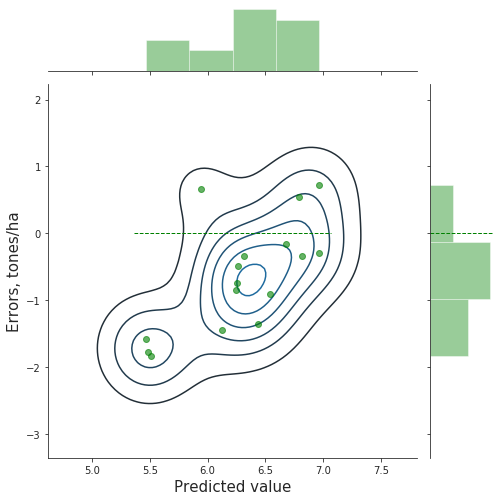

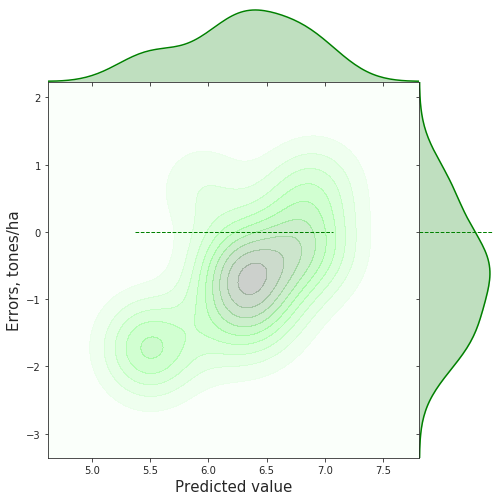

In [16]:
print_metrics(y_test, predicted_France, LR, r2 = True)
residuals_plots(y_test, predicted_France, color = 'green')

## Italy

Results: 
*   Median absolute error in the test sample - 3.9103
*   MAE in the test sample - 3.9764
*   Root mean square error in the test sample - 4.0348
*   Coefficient of determination in the training sample - 0.3244
*   Mean absolute percentage error in the test sample - 115.2073


In [17]:
data_italy = pd.read_csv('/media/mikhail/Data/ITMO/Reanalysis_grid_Europe/Processed_grid/Italy.csv', sep = ',')
data_italy.dropna(axis=1, inplace=True)
data_italy.drop('Entity', inplace=True, axis=1)
data_italy.drop('Greece_pressure', inplace=True, axis=1)
data_italy.head(10)

Precip_amount  Precip_days  Pressure_mean  Sweden_pressure  \
0      312.19240         38.0      824.96790       1002.46170   
1      332.24994         42.0      823.08580       1003.04160   
2      466.29880         58.0      821.62940       1009.54596   
3      337.80374         42.0      824.82960       1008.34420   
4      357.37668         46.0      818.11530       1004.89140   
5      332.77496         43.0      816.94440       1007.26660   
6      302.28406         37.0      817.50653       1002.95180   
7      364.52332         47.0      816.08450       1002.37256   
8      413.97040         51.0      814.29060       1009.15950   
9      356.08040         48.0      815.21870       1005.29070   

   Ireland_pressure  Portugal_pressure  Temperature_max  Temperature_min  \
0         995.21630         1013.98834        30.449190        -4.553965   
1         997.25440         1012.53150        30.173197        -6.701055   
2         993.74610         1009.40594        29.791723        -9.947467   
3         996.31190         1011.71810        29.460579        -6.262708   
4         996.11790         1012.11725        31.465017        -6.365860   
5         990.89276         1011.42180        29.604105        -7.904990   
6         995.52360         1013.38960        28.788496        -7.405155   
7         995.36950         1011.64386        28.606966        -9.034104   
8         992.91064         1009.18420        27.814734        -7.051416   
9         993.67240         1011.54816        29.183887        -4.909248   

   Temperature_SAT  Year  ...  Maize (tonnes per hectare)  \
0        1642.8204  1961  ...                      3.2882   
1        1408.0195  1962  ...                      2.9129   
2        1418.8585  1963  ...                      3.2949   
3        1568.5520  1964  ...                      3.6907   
4        1379.8136  1965  ...                      3.2278   
5        1592.0149  1966  ...                      3.5532   
6        1448.7306  1967  ...                      3.7961   
7        1569.0536  1968  ...                      4.1261   
8        1399.2858  1969  ...                      4.5235   
9        1394.8616  1970  ...                      4.6344   

   Soybeans (tonnes per hectare)  Potatoes (tonnes per hectare)  \
0                         1.9167                        10.3832   
1                         1.7824                         9.4531   
2                         1.8214                        11.3594   
3                         1.8333                        10.7440   
4                         1.8077                        10.1908   
5                         1.9455                        11.1140   
6                         2.0455                        11.8246   
7                         1.9588                        12.4119   
8                         2.0337                        12.9811   
9                         2.0482                        12.8052   

   Beans (tonnes per hectare)  Peas (tonnes per hectare)  \
0                      0.5124                     0.6701   
1                      0.4704                     0.8211   
2                      0.6283                     0.8249   
3                      0.6803                     0.8661   
4                      0.5788                     0.8912   
5                      0.6216                     0.9303   
6                      0.6827                     0.9778   
7                      0.7202                     0.9305   
8                      0.7832                     1.0015   
9                      0.8295                     1.3535   

   Barley (tonnes per hectare)  Total population (Gapminder)  \
0                       1.2690                    50052000.0   
1                       1.3616                    50442000.0   
2                       1.3736                    50856000.0   
3                       1.2798                    51273000.0   
4                       1.5290                    51677000.

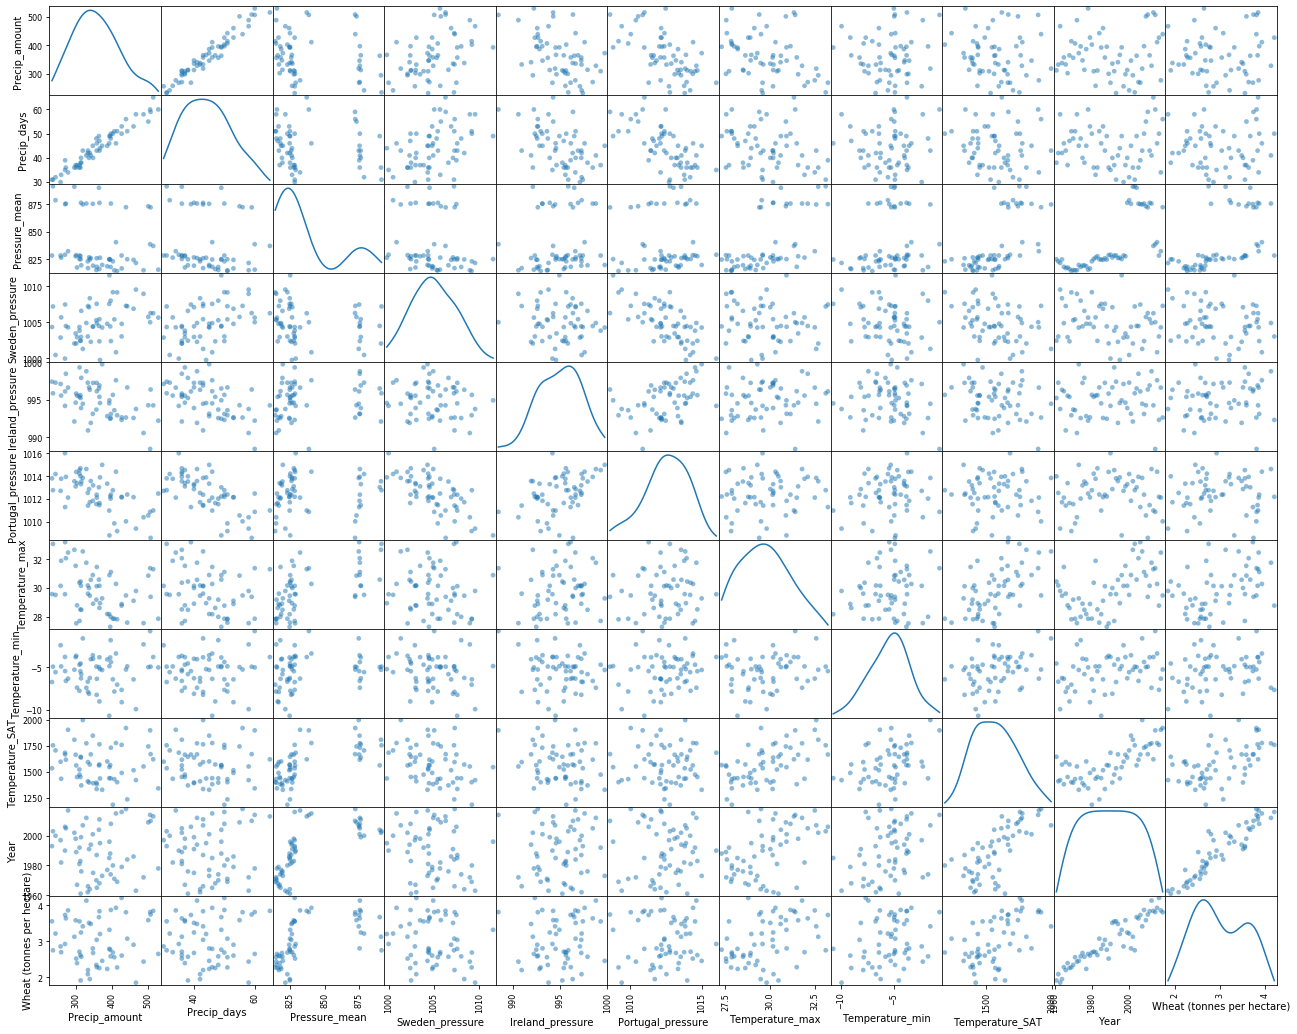

In [18]:
rcParams['figure.figsize'] = 22, 18

pd.plotting.scatter_matrix(data_italy.loc[:, "Precip_amount":"Wheat (tonnes per hectare)"], 
                           diagonal="kde", s = 90)
plt.show()

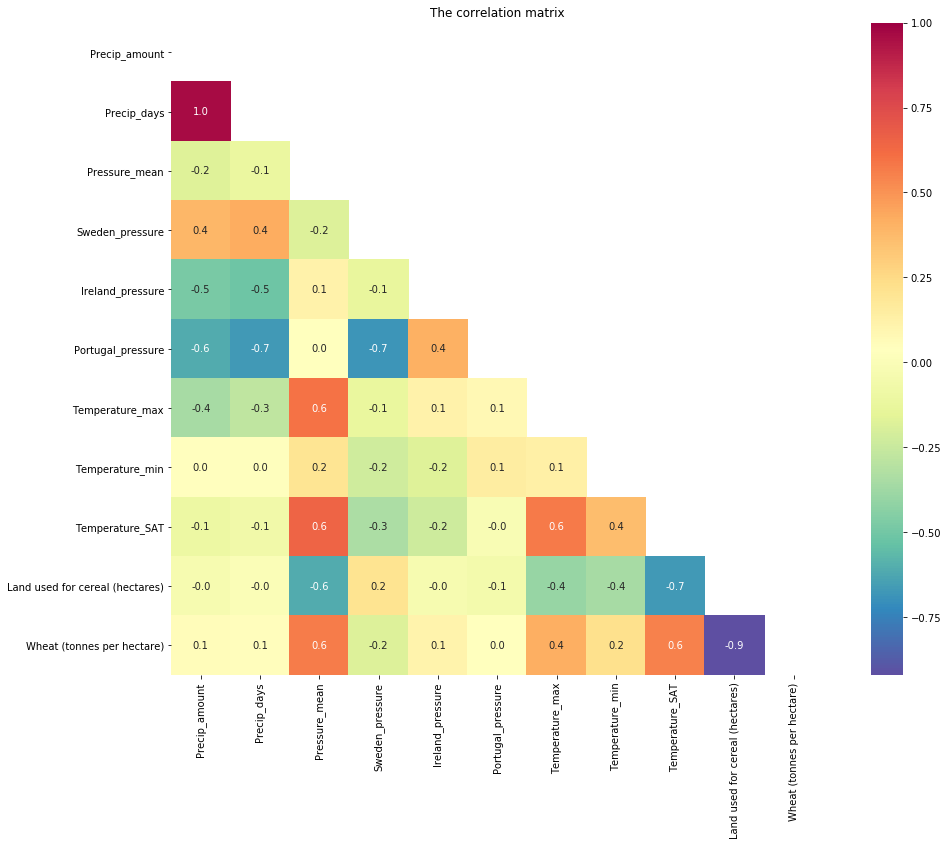

In [19]:
rcParams['figure.figsize'] = 17, 12

Newtable = data_italy[['Precip_amount', 'Precip_days', 'Pressure_mean', 'Sweden_pressure',
                'Ireland_pressure', 'Portugal_pressure', 'Temperature_max', 'Temperature_min',
                'Temperature_SAT','Land used for cereal (hectares)', 'Wheat (tonnes per hectare)']]
Newtable = Newtable.dropna()

corrs = Newtable.corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrs, cmap='Spectral_r', annot=True, fmt= '.1f', mask = mask, square = True)
plt.title('The correlation matrix')
plt.show()

### Checking samples for homogeneity

##### Cumulative sum method and statistical testing to divide the sample into homogeneous parts

The method of integral curves or accumulated (cumulative) sum was initially used in hydrology to check whether or not there are directional changes (trends) in the interannual dynamics of annual river flows. Subsequently, it was used for preliminary analysis of interannual variability of any environmental parameters.

The method is as follows. Graph: x-axis numbers refer to years, y-axis – the accumulated amount of average or total for the year parameter values. The accumulated amount for a given year is the sum of the values of the series from its very beginning to this year. For the first year of the series, this is the value itself, for the second year-the sum of the values of the first and second years, and so on. The points of accumulated sum on the chart are connected by a line. If there is no pronounced inter-annual trend in changing the values of the series, the curve is close to a straight line. If there are breaks on the curve, this may indicate that the sample is not uniform.

In [20]:
cum_sum(data_italy['Wheat (tonnes per hectare)'], data_italy['Year'])

No fractures were found


### Multiple linear regression

Predictors:
* Precip_amount
* Temperature_SAT
* Precip_days
* Pressure_mean
* Temperature_min
* Year

In [21]:
data_italy['year'] = data_italy['Year']
data_italy.set_index('year', inplace=True)
data_train = data_italy.loc[1961:2003]
data_test = data_italy.loc[2003:2018]

# Предикторы
scaler = StandardScaler()
X_train = scaler.fit_transform(data_train[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min', 'Year']])
X_test = scaler.transform(data_test[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min', 'Year']])
                          
y_train = data_train['Wheat (tonnes per hectare)']
y_test = data_test['Wheat (tonnes per hectare)']
                          
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# Обучение линейной регрессии
LR = LinearRegression()
LR.fit(X_train, y_train)
predicted_Italy = LR.predict(X_test)

Mean absolute error in the test sample - 0.30290068494129374
Median absolute error in the test sample - 0.29405222724845537
Root mean square error in the test sample - 0.3414616551046476
Mean absolute percentage error in the test sample - 8.171729023518893
Coefficient of determination in the training sample - 0.8244492055356136


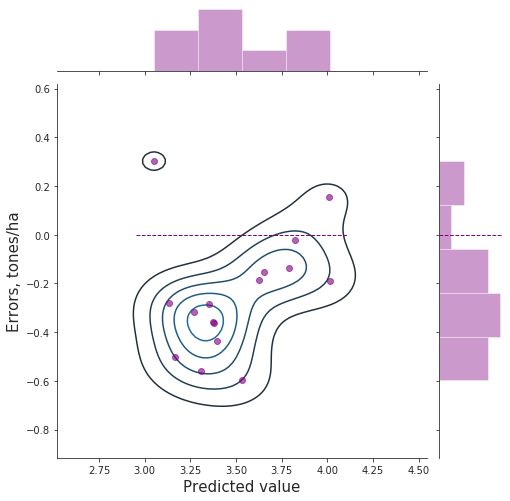

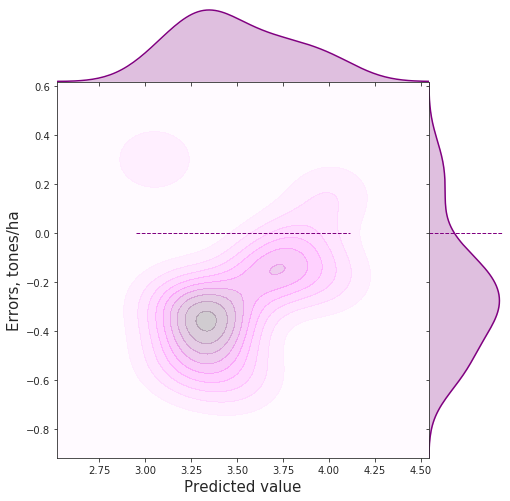

In [22]:
print_metrics(y_test, predicted_Italy, LR, r2 = True)
residuals_plots(y_test, predicted_Italy, color = 'purple')

## Spain

In [23]:
data_spain = pd.read_csv('/media/mikhail/Data/ITMO/Reanalysis_grid_Europe/Processed_grid/Spain.csv', sep = ',')
data_spain.dropna(axis=1, inplace=True)
data_spain.drop('Entity', inplace=True, axis=1)
data_spain.drop('Greece_pressure', inplace=True, axis=1)
data_spain.head(10)

Precip_amount  Precip_days  Pressure_mean  Sweden_pressure  \
0      202.46367         33.0     1016.92914       1002.46170   
1      313.34190         42.0     1015.79340       1003.04160   
2      366.58414         55.0     1012.74615       1009.54596   
3      272.55115         39.0     1015.32947       1008.34420   
4      212.32310         34.0     1016.05140       1004.89140   
5      352.63235         49.0     1014.90800       1007.26660   
6      241.76419         37.0     1016.85840       1002.95180   
7      288.50910         44.0     1014.57260       1002.37256   
8      429.83920         57.0     1012.22400       1009.15950   
9      309.42874         44.0     1014.50150       1005.29070   

   Ireland_pressure  Portugal_pressure  Temperature_max  Temperature_min  \
0         995.21630         1013.98834        32.340443        -3.689090   
1         997.25440         1012.53150        32.176704        -4.085170   
2         993.74610         1009.40594        32.771297        -7.647820   
3         996.31190         1011.71810        33.197018        -5.361032   
4         996.11790         1012.11725        35.350590        -6.783522   
5         990.89276         1011.42180        32.052307        -2.163602   
6         995.52360         1013.38960        31.730625        -5.226960   
7         995.36950         1011.64386        35.636047        -5.138569   
8         992.91064         1009.18420        31.912350        -5.686153   
9         993.67240         1011.54816        31.378597        -4.778692   

   Temperature_SAT  Year  ...  Maize (tonnes per hectare)  \
0        1809.3555  1961  ...                      2.3882   
1        1465.3802  1962  ...                      2.1408   
2        1425.7079  1963  ...                      2.4044   
3        1638.9487  1964  ...                      2.3392   
4        1619.2842  1965  ...                      2.3876   
5        1599.6742  1966  ...                      2.3938   
6        1412.6320  1967  ...                      2.5010   
7        1406.1920  1968  ...                      2.8168   
8        1348.9717  1969  ...                      3.0487   
9        1396.9450  1970  ...                      3.4278   

   Potatoes (tonnes per hectare)  Beans (tonnes per hectare)  \
0                        11.8126                      0.6341   
1                        10.1604                      0.5004   
2                        12.3557                      0.5493   
3                        11.6488                      0.5247   
4                        11.0710                      0.5265   
5                        11.8083                      0.5490   
6                        11.9349                      0.5373   
7                        11.8969                      0.5348   
8                        12.7156                      0.5601   
9                        13.3553                      0.6036   

   Peas (tonnes per hectare)  Barley (tonnes per hectare)  \
0                     0.7633                       1.2026   
1                     0.8009                       1.4916   
2                     0.8285                       1.4309   
3                     0.7359                       1.3953   
4                     0.5994                       1.3762   
5                     0.7868                       1.4997   
6                     0.8380                       1.7174   
7                     0.8008                       1.7894   
8                     0.8780                       1.8376   
9                     0.7444                       1.3953   

   Bananas (tonnes per hectare)  Total population (Gapminder)  \
0                       33.1895                    30730000.0   
1                       31.8125                    31075000.0   
2                       35.5104                    31433000.0   
3                       37.1633                    31792000.0   
4                       37.6162                    32146000.0   
5          

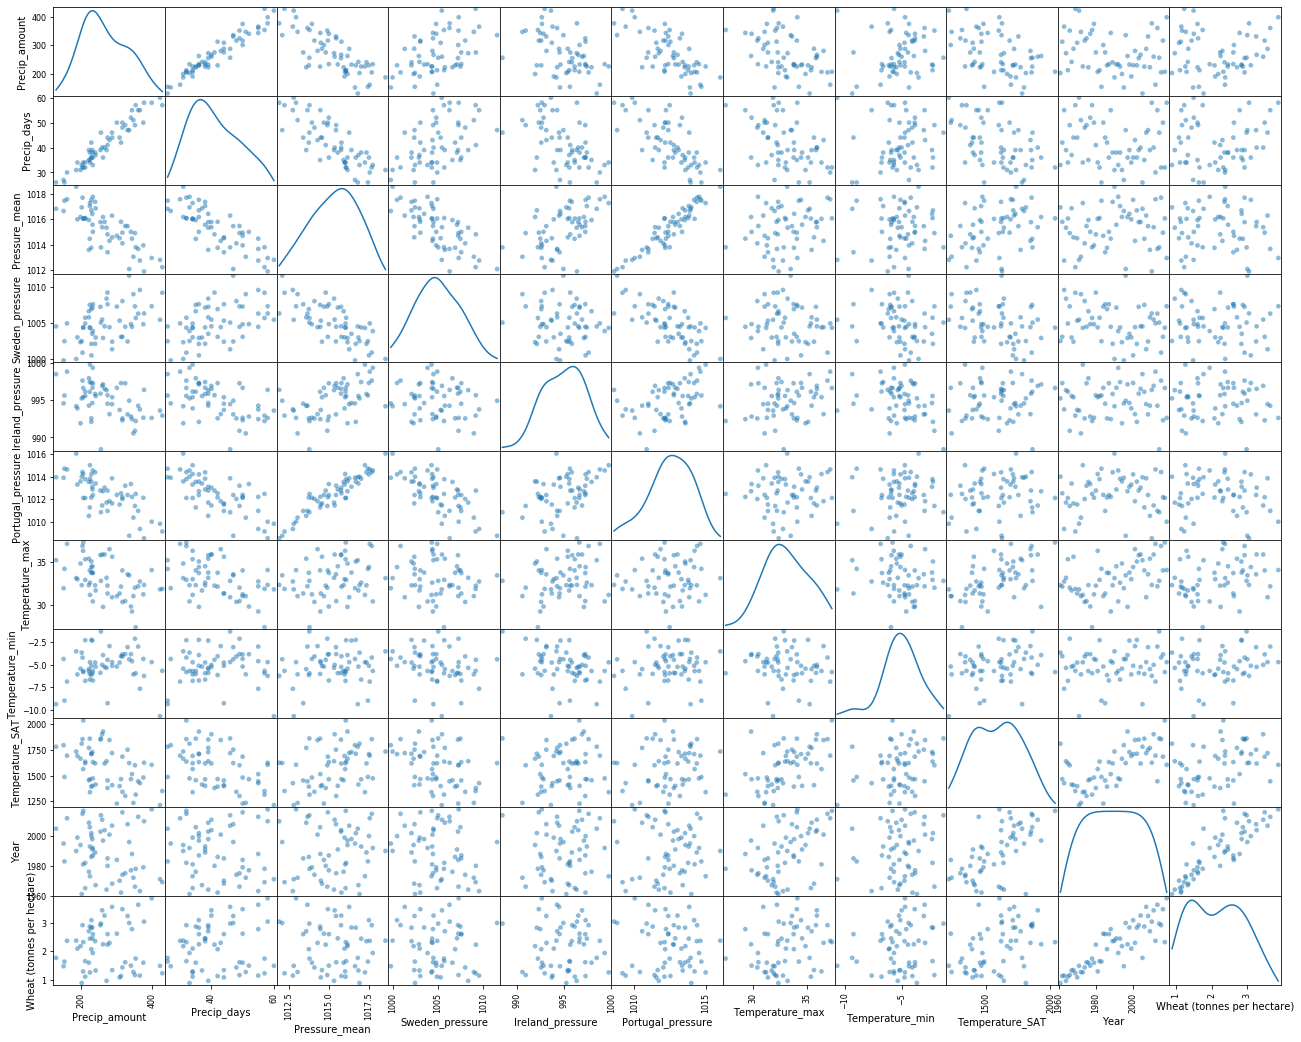

In [24]:
rcParams['figure.figsize'] = 22, 18

pd.plotting.scatter_matrix(data_spain.loc[:, "Precip_amount":"Wheat (tonnes per hectare)"], 
                           diagonal="kde", s = 90)
plt.show()

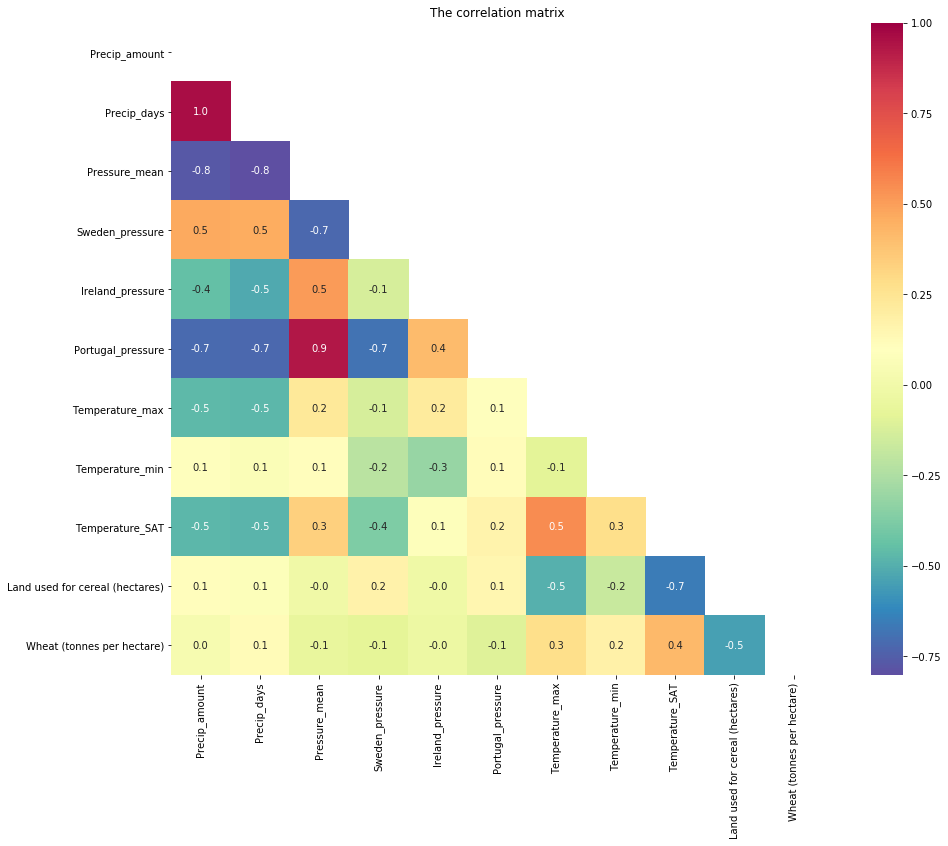

In [25]:
rcParams['figure.figsize'] = 17, 12

Newtable = data_spain[['Precip_amount', 'Precip_days', 'Pressure_mean', 'Sweden_pressure',
                'Ireland_pressure', 'Portugal_pressure', 'Temperature_max', 'Temperature_min',
                'Temperature_SAT','Land used for cereal (hectares)', 'Wheat (tonnes per hectare)']]
Newtable = Newtable.dropna()

corrs = Newtable.corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrs, cmap='Spectral_r', annot=True, fmt= '.1f', mask = mask, square = True)
plt.title('The correlation matrix')
plt.show()

### Checking samples for homogeneity

##### Cumulative sum method and statistical testing to divide the sample into homogeneous parts

The method of integral curves or accumulated (cumulative) sum was initially used in hydrology to check whether or not there are directional changes (trends) in the interannual dynamics of annual river flows. Subsequently, it was used for preliminary analysis of interannual variability of any environmental parameters.

The method is as follows. Graph: x-axis numbers refer to years, y-axis – the accumulated amount of average or total for the year parameter values. The accumulated amount for a given year is the sum of the values of the series from its very beginning to this year. For the first year of the series, this is the value itself, for the second year-the sum of the values of the first and second years, and so on. The points of accumulated sum on the chart are connected by a line. If there is no pronounced inter-annual trend in changing the values of the series, the curve is close to a straight line. If there are breaks on the curve, this may indicate that the sample is not uniform.

In [26]:
cum_sum(data_spain['Wheat (tonnes per hectare)'], data_spain['Year'])

No fractures were found


### Multiple linear regression

Predictors:
* Precip_amount
* Temperature_SAT
* Precip_days
* Pressure_mean
* Temperature_min
* Year

In [27]:
data_italy['year'] = data_italy['Year']
data_italy.set_index('year', inplace=True)
data_train = data_italy.loc[1961:2003]
data_test = data_italy.loc[2003:2018]

# Предикторы
scaler = StandardScaler()
X_train = scaler.fit_transform(data_train[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min', 'Year']])
X_test = scaler.transform(data_test[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min', 'Year']])
                          
y_train = data_train['Wheat (tonnes per hectare)']
y_test = data_test['Wheat (tonnes per hectare)']
                          
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# Обучение линейной регрессии
LR = LinearRegression()
LR.fit(X_train, y_train)
predicted_Spain = LR.predict(X_test)

Mean absolute error in the test sample - 0.30290068494129374
Median absolute error in the test sample - 0.29405222724845537
Root mean square error in the test sample - 0.3414616551046476
Mean absolute percentage error in the test sample - 8.171729023518893
Coefficient of determination in the training sample - 0.8244492055356136


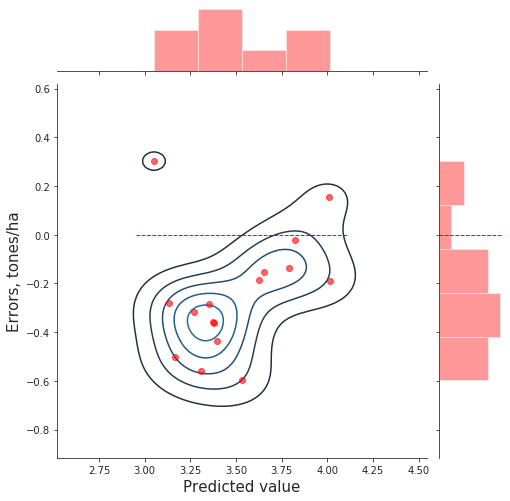

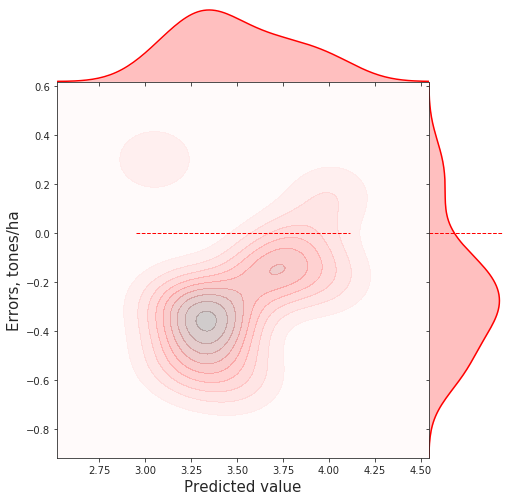

In [28]:
print_metrics(y_test, predicted_Spain, LR, r2 = True)
residuals_plots(y_test, predicted_Spain, color = 'red')

## Czech Republic

In [29]:
data_cz = pd.read_csv('/media/mikhail/Data/ITMO/Reanalysis_grid_Europe/Processed_grid/Czech Republic.csv', sep = ',')
data_cz.dropna(axis=1, inplace=True)
data_cz.drop('Entity', inplace=True, axis=1)
data_cz.drop('Greece_pressure', inplace=True, axis=1)
data_cz.head(10)

Precip_amount  Precip_days  Pressure_mean  Sweden_pressure  \
0      236.90952         57.0     1019.72130       1004.35410   
1      261.69336         63.0     1015.48680       1002.29987   
2      365.54355         78.0     1015.23890        999.78370   
3      291.06827         54.0     1017.60360       1011.53320   
4      251.62720         58.0     1019.54540       1002.88885   
5      233.82738         52.0     1017.39514       1003.46533   
6      286.72226         67.0     1015.69130       1002.97550   
7      305.16748         69.0     1017.80220       1000.47534   
8      300.80610         68.0     1015.02390       1004.38640   
9      276.06805         54.0     1017.70856       1002.06700   

   Ireland_pressure  Portugal_pressure  Temperature_max  Temperature_min  \
0         997.39480         1013.81060        29.180721       -18.573154   
1         991.89355         1013.57764        33.725000       -15.198441   
2         994.54443         1013.89580        28.035152       -12.810456   
3         994.90420         1008.80660        30.914106       -18.143785   
4         997.08496         1012.71330        31.069088       -16.072071   
5         994.59540         1013.10770        33.071995       -19.110321   
6         993.88010         1013.30090        29.083517       -16.285055   
7         997.26780         1014.19055        34.305950       -16.201557   
8         993.10876         1011.83990        28.685057       -14.457433   
9         992.08057         1013.55566        32.528786       -19.198270   

   Temperature_SAT  Year  Wheat (tonnes per hectare)  \
0       1113.89430  1993                      4.2350   
1        989.57990  1994                      4.5800   
2        882.71570  1995                      4.6016   
3        988.33460  1996                      4.6671   
4        879.50323  1997                      4.4100   
5       1082.73240  1998                      4.2143   
6       1027.12410  1999                      4.6457   
7       1219.02400  2000                      4.2085   
8        927.59020  2001                      4.8483   
9       1128.99770  2002                      4.5551   

   Maize (tonnes per hectare)  Soybeans (tonnes per hectare)  \
0                      4.8746                         1.1180   
1                      3.3896                         1.0217   
2                      4.2840                         1.2912   
3                      5.0927                         1.4234   
4                      6.9250                         1.3655   
5                      6.0948                         1.2529   
6                      6.6037                         1.6027   
7                      6.4285                         1.2463   
8                      6.5978                         1.5894   
9                      8.7322                         2.1289   

   Potatoes (tonnes per hectare)  Peas (tonnes per hectare)  \
0                        23.3019                     2.4462   
1                        16.0557                     2.4219   
2                        17.0815                     2.5006   
3                        21.0042                     2.5452   
4                        19.3000                     2.1247   
5                        21.1505                     2.3890   
6                        19.6884                     2.6531   
7                        21.3300                     2.2248   
8                        20.8818                     2.5685   
9                        23.5121                     2.0073   

   Barley (tonnes per hectare)  Total population (Gapminder)  \
0                       3.7999                    10359000.0   
1                       3.7780                    10361000.0   
2                       3.8386                    10358000.0   
3                       3.7716                    10350000.0   
4                       3.8431                    10338000.0   
5                       3.6232                    

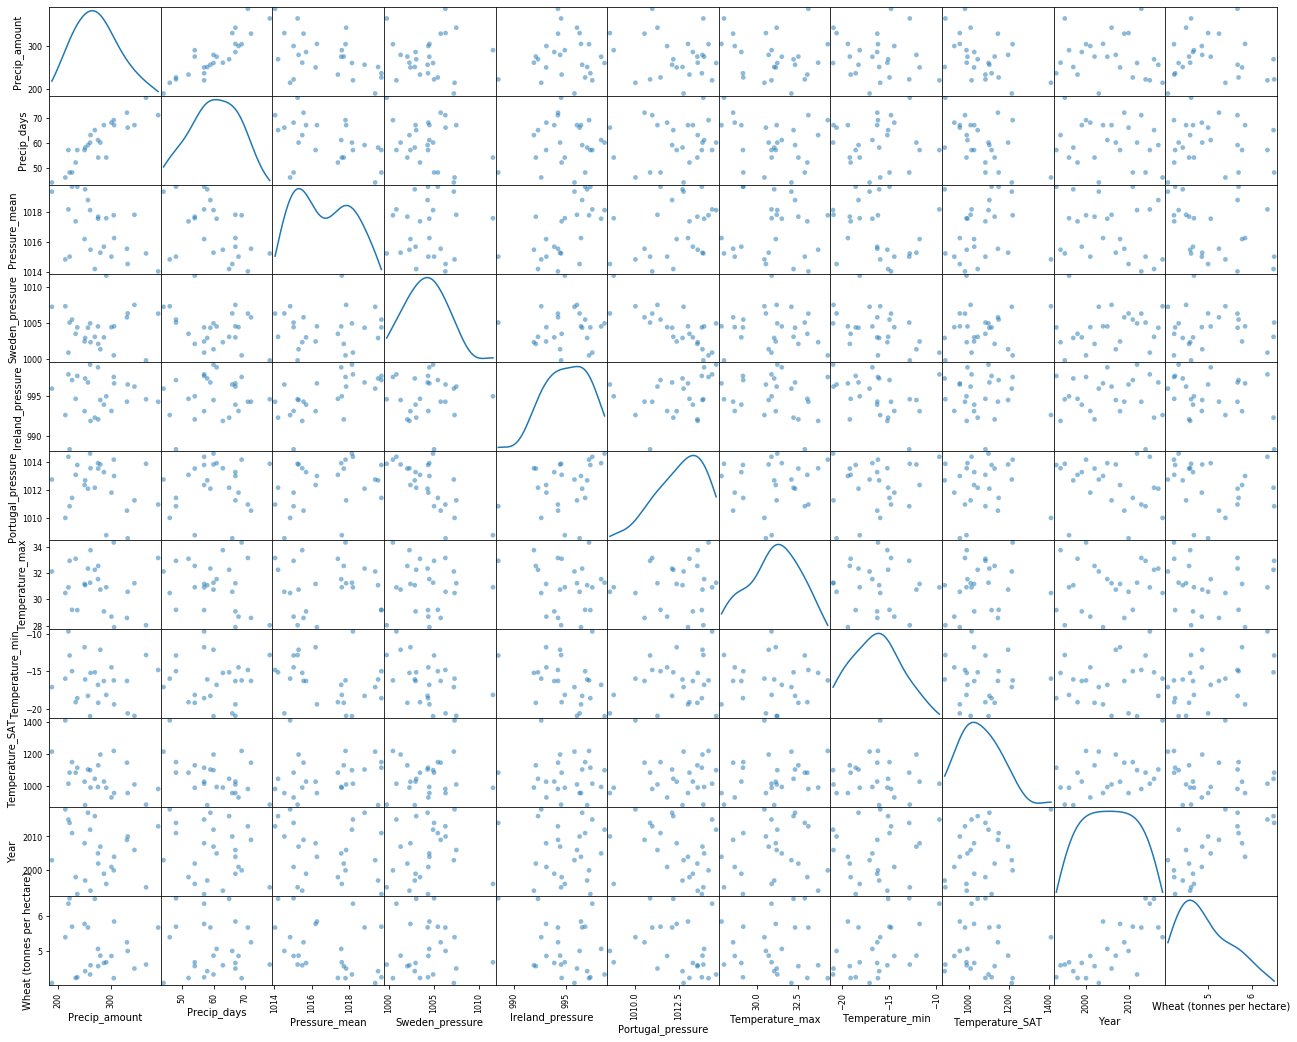

In [30]:
rcParams['figure.figsize'] = 22, 18

pd.plotting.scatter_matrix(data_cz.loc[:, "Precip_amount":"Wheat (tonnes per hectare)"], 
                           diagonal="kde", s = 90)
plt.show()

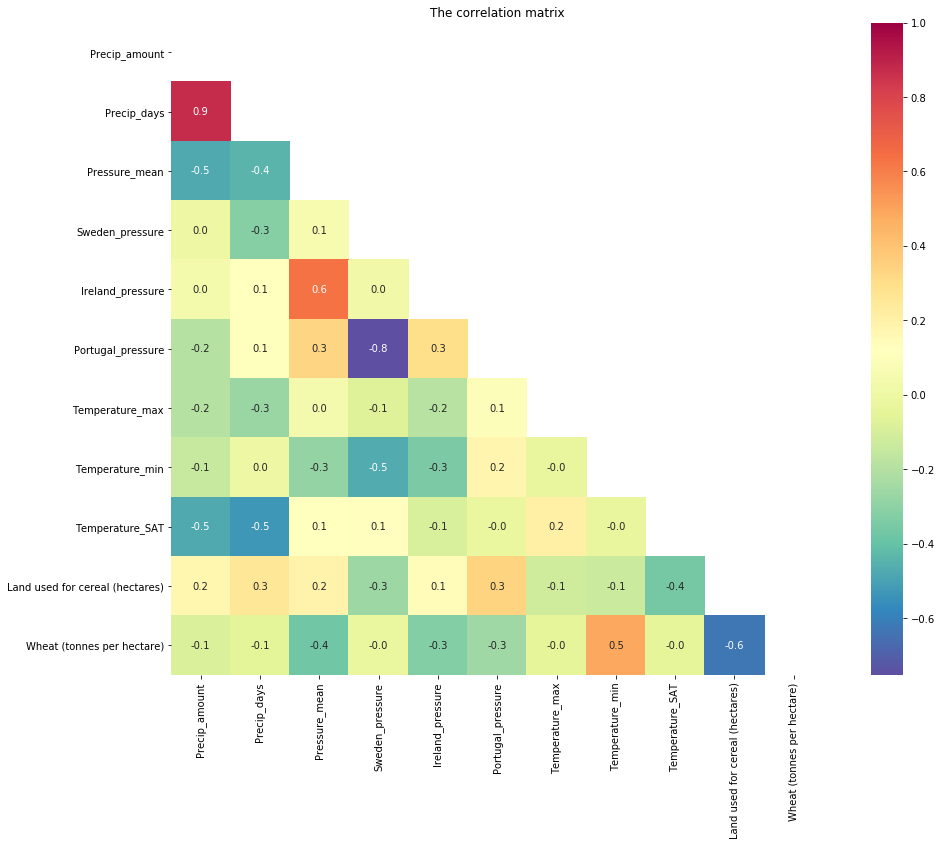

In [31]:
rcParams['figure.figsize'] = 17, 12

Newtable = data_cz[['Precip_amount', 'Precip_days', 'Pressure_mean', 'Sweden_pressure',
                'Ireland_pressure', 'Portugal_pressure', 'Temperature_max', 'Temperature_min',
                'Temperature_SAT','Land used for cereal (hectares)', 'Wheat (tonnes per hectare)']]
Newtable = Newtable.dropna()

corrs = Newtable.corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrs, cmap='Spectral_r', annot=True, fmt= '.1f', mask = mask, square = True)
plt.title('The correlation matrix')
plt.show()

### Checking samples for homogeneity

##### Cumulative sum method and statistical testing to divide the sample into homogeneous parts

The method of integral curves or accumulated (cumulative) sum was initially used in hydrology to check whether or not there are directional changes (trends) in the interannual dynamics of annual river flows. Subsequently, it was used for preliminary analysis of interannual variability of any environmental parameters.

The method is as follows. Graph: x-axis numbers refer to years, y-axis – the accumulated amount of average or total for the year parameter values. The accumulated amount for a given year is the sum of the values of the series from its very beginning to this year. For the first year of the series, this is the value itself, for the second year-the sum of the values of the first and second years, and so on. The points of accumulated sum on the chart are connected by a line. If there is no pronounced inter-annual trend in changing the values of the series, the curve is close to a straight line. If there are breaks on the curve, this may indicate that the sample is not uniform.

In [32]:
cum_sum(data_cz['Wheat (tonnes per hectare)'], data_cz['Year'])

No fractures were found


### Multiple linear regression

Predictors:
* Precip_amount
* Temperature_SAT
* Precip_days
* Pressure_mean
* Temperature_min
* Year

In [33]:
data_cz['year'] = data_cz['Year']
data_cz.set_index('year', inplace=True)
data_train = data_cz.loc[1993:2003]
data_test = data_cz.loc[2003:2018]

# Предикторы
scaler = StandardScaler()
X_train = scaler.fit_transform(data_train[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min', 'Year']])
X_test = scaler.transform(data_test[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min','Year']])
                          
y_train = data_train['Wheat (tonnes per hectare)']
y_test = data_test['Wheat (tonnes per hectare)']
                          
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# Обучение линейной регрессии
LR = LinearRegression()
LR.fit(X_train, y_train)
predicted_Cz = LR.predict(X_test)

Mean absolute error in the test sample - 0.906244844357061
Median absolute error in the test sample - 0.7794314413398293
Root mean square error in the test sample - 1.0908948406711096
Mean absolute percentage error in the test sample - 15.696158607644284
Coefficient of determination in the training sample - 0.8204887898803757


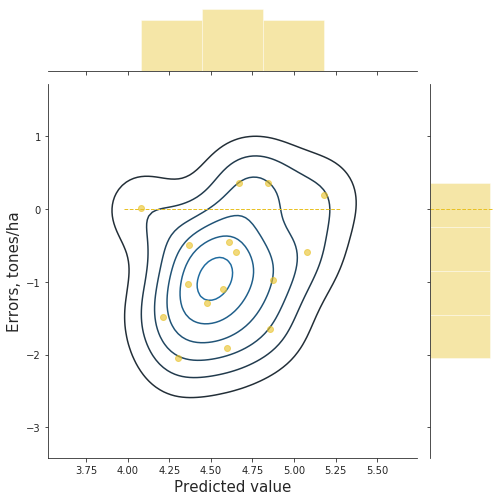

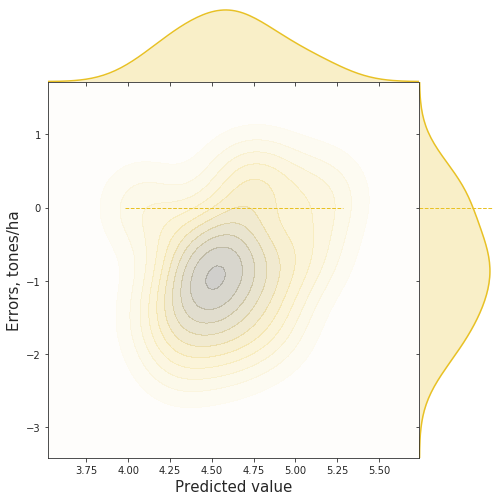

In [34]:
print_metrics(y_test, predicted_Cz, LR, r2 = True)
residuals_plots(y_test, predicted_Cz, color = '#E8C125')

## Comparing yields in different countries

In [35]:
data = pd.DataFrame({'Germany_wheat': data_germany['Wheat (tonnes per hectare)'],
                     'France_wheat': data_france['Wheat (tonnes per hectare)'],
                     'Italy_wheat': data_italy['Wheat (tonnes per hectare)'],
                     'Spain_wheat': np.array(data_spain['Wheat (tonnes per hectare)']),
                     'Cz_wheat': data_cz['Wheat (tonnes per hectare)'],
                     'Germany_SAT': data_germany['Temperature_SAT'],
                     'France_SAT': data_france['Temperature_SAT'],
                     'Italy_SAT': data_italy['Temperature_SAT'],
                     'Spain_SAT': np.array(data_spain['Temperature_SAT']),
                     'Cz_SAT': data_cz['Temperature_SAT']})
data.reset_index()
data.dropna(inplace=True)
data.head(10)

Germany_wheat  France_wheat  Italy_wheat  Spain_wheat  Cz_wheat  \
year                                                                    
1993         6.5841        6.4739       3.5533       2.4492    4.2350   
1994         6.7684        6.6685       3.4796       2.1843    4.5800   
1995         6.8882        6.5079       3.2013       1.4761    4.6016   
1996         7.2932        7.1361       3.3170       3.0016    4.6671   
1997         7.2902        6.6288       2.8563       2.2498    4.4100   
1998         7.2035        7.6063       3.5818       2.8424    4.2143   
1999         7.5411        7.2395       3.2434       2.0987    4.6457   
2000         7.2826        7.1175       3.2133       3.0997    4.2085   
2001         7.8827        6.6169       2.8013       2.3003    4.8483   
2002         6.9056        7.4455       3.1247       2.8347    4.5551   

      Germany_SAT  France_SAT  Italy_SAT  Spain_SAT      Cz_SAT  
year                                                             
1993   1134.85490   1308.0712  1532.6416  1462.8168  1113.89430  
1994    990.49945   1252.0007  1665.8239  1663.8657   989.57990  
1995    828.95660   1138.2351  1434.9854  1795.1824   882.71570  
1996    879.54960   1146.9177  1543.1274  1621.0078   988.33460  
1997    878.92426   1325.7598  1595.4042  1927.7373   879.50323  
1998   1103.05250   1291.6218  1662.5446  1728.0435  1082.73240  
1999   1045.85800   1336.3673  1635.1565  1690.5135  1027.12410  
2000   1153.15780   1302.8635  1703.8252  1708.3032  1219.02400  
2001    934.54110   1330.5294  1845.2649  1844.7100   927.59020  
2002   1087.68180   1374.2340  1806.0596  1711.6313  1128.99770

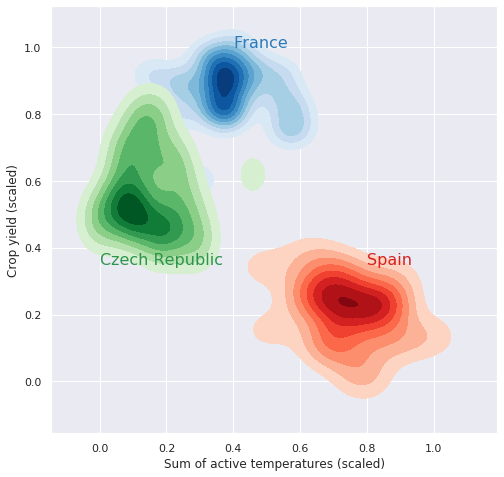

In [36]:
from sklearn.preprocessing import MinMaxScaler

SAT = np.vstack((np.array(data['France_SAT']), 
                 np.array(data['Spain_SAT']), 
                 np.array(data['Cz_SAT'])))
SAT = np.ravel(SAT)

Wheat = np.vstack((np.array(data['France_wheat']), 
                   np.array(data['Spain_wheat']), 
                   np.array(data['Cz_wheat'])))
Wheat = np.ravel(Wheat)

zer = np.full(len(data['France_SAT']), 'France')
ones = np.full(len(data['Spain_SAT']), 'Spain')
tres = np.full(len(data['Cz_SAT']), 'Czech')
code = np.vstack((zer, ones, tres))
code = np.ravel(code)

new_data = pd.DataFrame({'SAT': SAT, 
                         'Wheat': Wheat,
                         'Code': code})
new_data['Sum of active temperatures (scaled)'] = new_data['SAT']
new_data['Crop yield (scaled)'] = new_data['Wheat']
scaler = MinMaxScaler()
new_data[['Sum of active temperatures (scaled)', 'Crop yield (scaled)']] = scaler.fit_transform(new_data[['SAT', 'Wheat']])


sns.set(style="darkgrid")

# Subset the iris dataset by species
france = new_data.query("Code == 'France'")
spain = new_data.query("Code == 'Spain'")
czech = new_data.query("Code == 'Czech'")

# Set up the figure
f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(france['Sum of active temperatures (scaled)'], france['Crop yield (scaled)'],
                 cmap="Blues", shade=True, shade_lowest=False)
ax = sns.kdeplot(spain['Sum of active temperatures (scaled)'], spain['Crop yield (scaled)'],
                 cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(czech['Sum of active temperatures (scaled)'], czech['Crop yield (scaled)'],
                 cmap="Greens", shade=True, shade_lowest=False)

blue = sns.color_palette("Blues")[-2]
red = sns.color_palette("Reds")[-2]
green = sns.color_palette("Greens")[-2]
ax.text(0.4, 1.0, "France", size=16, color=blue)
ax.text(0.8, 0.35, "Spain", size=16, color=red)
ax.text(0.0, 0.35, "Czech Republic", size=16, color=green)
plt.show()

Thus, it is clear that the dependencies for countries are not trivial, which is why we built models separately for each country.